In [1]:
import importlib
import parser
import df_parser
import os
importlib.reload(parser)
importlib.reload(df_parser)
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from treys import Card, Evaluator
from kan import *

In [2]:
# Load Pluribus data
directory_path = '..\phh-dataset\data\pluribus'
tables = os.listdir(directory_path)
table_data = {}

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\2794823244.py:2: SyntaxWarning: invalid escape sequence '\p'
  directory_path = '..\phh-dataset\data\pluribus'


In [3]:
tables_df = {}

for table in tables: 
    directory_path = f'..\phh-dataset\data\pluribus\{table}'
    hands = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith(".phh"):
            file_path = os.path.join(directory_path, file_name)
            try:
                # Parse the .phh file and add the Hand object to the list
                hand = df_parser.parse_from_file(file_path)
                hands.append(hand)
            except Exception as e:
                print(f"Error parsing file {file_name}: {e}")
    tables_df[table] = hands

<string>:4: SyntaxWarning: invalid escape sequence '\{'
<>:4: SyntaxWarning: invalid escape sequence '\{'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<string>:4: SyntaxWarning: invalid escape sequence '\{'
<>:4: SyntaxWarning: invalid escape sequence '\{'
<>:4: SyntaxWarning: invalid escape sequence '\p'
C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\3564343776.py:4: SyntaxWarning: invalid escape sequence '\{'
  directory_path = f'..\phh-dataset\data\pluribus\{table}'
C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\3564343776.py:4: SyntaxWarning: invalid escape sequence '\p'
  directory_path = f'..\phh-dataset\data\pluribus\{table}'


Error parsing file 0.phh: All arrays must be of the same length
Error parsing file 23.phh: All arrays must be of the same length
Error parsing file 204.phh: All arrays must be of the same length
Error parsing file 88.phh: All arrays must be of the same length
Error parsing file 76.phh: All arrays must be of the same length
Error parsing file 128.phh: All arrays must be of the same length
Error parsing file 43.phh: All arrays must be of the same length
Error parsing file 53.phh: All arrays must be of the same length


In [4]:
def hand_strength(hand):
    chen_base = {
        'A': 10,
        'K': 8,
        'Q': 7,
        'J': 6,
        'T': 5,
        '9': 4.5,
        '8': 4,
        '7': 3.5,
        '6': 3,
        '5': 2.5,
        '4': 2,
        '3': 1.5,
        '2': 1
    }
    
    rank_value = {
        'A': 14,
        'K': 13,
        'Q': 12,
        'J': 11,
        'T': 10,
        '9': 9,
        '8': 8,
        '7': 7,
        '6': 6,
        '5': 5,
        '4': 4,
        '3': 3,
        '2': 2
    }
    
    # Parse the two cards
    if len(hand) != 4:
        raise ValueError(f"Input should be exactly 4 characters, not {hand}")
    
    card1, card2 = hand[:2], hand[2:]
    rank1, suit1 = card1[0], card1[1]
    rank2, suit2 = card2[0], card2[1]
    
    # Base score: take the higher of the two card's Chen score.
    base = max(chen_base[rank1], chen_base[rank2])
    
    score = base
    
    # Check for a pair
    if rank1 == rank2:
        score *= 2
        if score < 5:
            score = 5  # minimum score for a pair is 5 according to Chen
    else:
        # Add bonus for suited cards (if not a pair)
        if suit1 == suit2:
            score += 2
        
        # Compute the gap: difference in card values minus 1
        gap = abs(rank_value[rank1] - rank_value[rank2]) - 1
        if gap < 0:
            gap = 0
        
        # Subtract penalty based on gap
        if gap == 0:
            gap_penalty = 0
        elif gap == 1:
            gap_penalty = 1
        elif gap == 2:
            gap_penalty = 2
        elif gap == 3:
            gap_penalty = 4
        else:  # gap >= 4
            gap_penalty = 5
        
        score -= gap_penalty
    
    # Make sure the score doesn't go negative
    if score < 0:
        score = 0
    
    return score

In [5]:
def position(hand):
    hand["Position"] = hand.index + 1

In [6]:
def parse_card(card):
    """Parse a card to extract rank and suit."""
    rank_translation = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7,
                        '8': 8, '9': 9, 'T': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14} 
    rank = rank_translation[card[:-1]]  # Convert rank to numerical value
    suit = card[-1]  # Last character is the suit ('h', 'd', 'c', 's')
    return rank, suit

def wetness(board):
    parsed_board = [parse_card(card) for card in board]
    ranks = [card[0] for card in parsed_board]
    suits = [card[1] for card in parsed_board]
    ranks.sort()

    suit_counts = Counter(suits)
    flush_score = max(suit_counts.values()) - 2 if max(suit_counts.values()) >= 2 else 0

    # Straight potential
    unique_ranks = sorted(set(ranks)) 
    straight_score = 0
    for i in range(len(unique_ranks) - 2): 
        if unique_ranks[i+1] - unique_ranks[i] <= 1 and unique_ranks[i+2] - unique_ranks[i+1] <= 1:
            straight_score += 1
    if len(unique_ranks) >= 4 and unique_ranks[-1] - unique_ranks[-4] <= 3:
        straight_score += 1

    # Paired cards
    rank_counts = Counter(ranks)
    pairs = sum(1 for count in rank_counts.values() if count >= 2)
    pair_score = pairs

    # High cards
    high_cards = {10, 11, 12, 13, 14}  # 10, J, Q, K, A
    high_card_score = sum(1 for rank in ranks if rank in high_cards) * 0.5

    # Total wetness score
    wetness_score = flush_score + straight_score + pair_score + high_card_score
    return wetness_score

In [7]:
reached_river_hands = []

# Iterate through the entire dictionary
# If Pluribus reaches the river in any hand, append to list
for key, dataframes in tables_df.items():  
    for df in dataframes:  
        if df.shape[1] >= 8:
            if (df["Player"] == "Pluribus").any() and df.iloc[:, 5].any():
                reached_river_hands.append(df)

In [8]:
pluribus_reach_river_hands = []

for hand in reached_river_hands:
    if hand.loc[hand["Player"] == "Pluribus"].iloc[:,5].any() == True:
        pluribus_reach_river_hands.append(hand)

In [9]:
pluribus_reach_river_hands[0].iloc[:, 2:5]

# We now calculate equity on the river.
evaluator = Evaluator()

river_equities = []

for hand in pluribus_reach_river_hands:
    # Replace "f" with None in specific columns excluding river
    columns_to_replace = hand.iloc[:, 2:5]
    hand.iloc[:, 2:5] = columns_to_replace.applymap(lambda x: None if "f" in str(x) else x)

    # Drop rows with missing values
    showdown = hand.dropna()

    # Extract and verify board cards
    flop = hand.columns[3]  # This might not give card strings
    flop = [flop[0:2], flop[2:4], flop[4:6]]  # Check if slicing works

    turn = [hand.columns[4]]
    river = [hand.columns[5]]
    board = [Card.new(card) for card in flop + turn + river]

    # Calculate equity
    equity = []
    for index, row in showdown.iterrows():
        hole_cards = row["Hole Cards"]
        player_hand = [Card.new(hole_cards[:2]), Card.new(hole_cards[2:])]
        
        player_score = evaluator.evaluate(board, player_hand)
        equity.append(player_score)
    showdown["Equity"] = equity
    river_equities.append(showdown)

C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\1171911438.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  hand.iloc[:, 2:5] = columns_to_replace.applymap(lambda x: None if "f" in str(x) else x)
C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\1171911438.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  showdown["Equity"] = equity
C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\1171911438.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  hand.iloc[:, 2:5] = columns_to_replace.applymap(lambda x: None if "f" in str(x) else x)
C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\1171911438.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [10]:
river_equities[7]

,Player,Hole Cards,Preflop,Qd9d2d,Td,7d,Pot Size,Profits,Equity
1,Pluribus,8s9s,cc,"cc, cbr 804",cbr 1054,cbr 2108,6551,2133,1238
4,MrWhite,9c9h,cbr 225,"cbr 277, cc",cc,f,6551,-2083,1238


In [11]:
# Add wetness and hand strength feature
for hand in river_equities:
    flop = hand.columns[3]  # This might not give card strings
    flop = [flop[0:2], flop[2:4], flop[4:6]]  # Check if slicing works
    turn = [hand.columns[4]]
    river = [hand.columns[5]]
    board = flop + turn + river
    wetness_score = wetness(board)
    hand["Wetness"] = wetness_score

C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\2738116964.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Wetness"] = wetness_score
C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\2738116964.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Wetness"] = wetness_score
C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\2738116964.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [12]:
len(river_equities)
river_equities[5]

,Player,Hole Cards,Preflop,Ad4h2h,2d,Ts,Pot Size,Profits,Equity,Wetness
1,MrWhite,6h5s,cc,"cc, cc",cc,cbr 500,1450,525,5996,2.0
4,Pluribus,7hKh,cbr 225,cbr 250,cc,f,1450,-475,5968,2.0


In [13]:
# Add position feature
for hand in river_equities:
    position(hand)
    hand["Hand Strength"] = hand["Hole Cards"].apply(hand_strength)

C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\2771689680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Position"] = hand.index + 1
C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\3692346498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Hand Strength"] = hand["Hole Cards"].apply(hand_strength)
C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\2771689680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [14]:
len(river_equities)

877

In [44]:
combined_df

,Player,Hole Cards,Preflop,5d6h2h,3h,Js,Pot Size,Profits,Equity,Wetness,...,9c2c3h,6c2h9h,7h7s6d,3dQc2c,9hTsJh,3h7s5c,3c9hJh,7dKsQd,3s6c8c,QsAdQh
0,Pluribus,4hAc,cc,"cc, cc","cc, cc","cc, sm 4hAc",1160,530,1608,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MrBlue,Ah6s,cc,cbr 130,cbr 300,"cc, sm",1160,-530,5109,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MrBlonde,Qd9d,cc,NaN,cc,NaN,1550,-250,5194,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MrWhite,AsJh,cbr 250,NaN,cc,NaN,1550,-250,5105,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pluribus,AdTd,cc,NaN,cc,NaN,1550,550,2963,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,MrWhite,JcQc,cbr 225,NaN,NaN,NaN,450,275,3766,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cc,NaN,NaN
1821,Pluribus,7d6d,cbr 1100,NaN,NaN,NaN,8025,2275,3106,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cbr 1125,NaN
1822,Gogo,7c7s,"cbr 200, cc",NaN,NaN,NaN,8025,-2225,3095,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cc,NaN
1823,Gogo,4cKh,cc,NaN,NaN,NaN,961,-312,3768,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cc


In [48]:
cols_to_keep = ["Player", "Hole Cards", "Profits", "Equity", "Wetness", "Position","Hand Strength"]
for i,table in enumerate(river_equities):
    river_equities[i] = table[cols_to_keep]

In [58]:
Plurb.sort_values(by='Hand Strength', ascending=False)

,Player,Hole Cards,Profits,Equity,Wetness,Position,Hand Strength,ProfitBinary
577,Pluribus,AsAh,1152,2525,2.5,6,20.0,1
903,Pluribus,AhAc,4199,380,3.5,5,20.0,1
1485,Pluribus,AdAs,-1475,1648,2.5,3,20.0,0
1013,Pluribus,AdAh,-1125,3398,2.5,4,20.0,0
999,Pluribus,AdAc,10150,1613,1.0,6,20.0,1
...,...,...,...,...,...,...,...,...
967,Pluribus,2d8d,1260,1609,2.0,2,1.0,1
322,Pluribus,2s6s,625,3250,1.0,2,1.0,1
751,Pluribus,9c5d,550,7097,1.0,2,0.5,1
1582,Pluribus,2sTh,800,3464,3.0,2,0.0,1


In [50]:
import torch
import copy
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

seed = 1

cpu


In [60]:
combined_df = pd.concat(river_equities, ignore_index=True)
Plurb = combined_df[combined_df['Player'] == 'Pluribus']
X = Plurb[['Wetness','Position','Hand Strength']].to_numpy()
Plurb['ProfitBinary'] = (Plurb['Profits'] > 0).astype(int)
y = Plurb['ProfitBinary']

C:\Users\xrli2\AppData\Local\Temp\ipykernel_3424\899298195.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Plurb['ProfitBinary'] = (Plurb['Profits'] > 0).astype(int)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.from_numpy(X_train_scaled).float().to(device)
X_test_tensor  = torch.from_numpy(X_test_scaled).float().to(device)

y_train_tensor = torch.from_numpy(y_train.to_numpy()).float().unsqueeze(1).to(device)
y_test_tensor  = torch.from_numpy(y_test.to_numpy()).float().unsqueeze(1).to(device)

dataset = {
    'train_input': X_train_tensor,
    'test_input':  X_test_tensor,
    'train_label': y_train_tensor,
    'test_label':  y_test_tensor
}

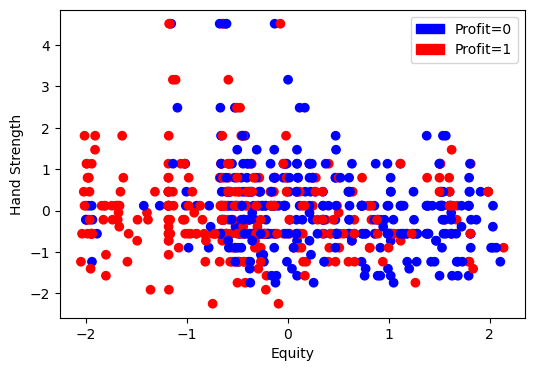

In [54]:
plt.figure(figsize=(6, 4))
plt.scatter(
    X_train_scaled[:, 0],  # Equity
    X_train_scaled[:, 3],
    c=y_train,      # color by label
    cmap='bwr'
)
plt.xlabel("Equity")
plt.ylabel("Hand Strength")
blue_patch = mpatches.Patch(color='blue', label='Profit=0')
red_patch = mpatches.Patch(color='red', label='Profit=1')
plt.legend(handles=[blue_patch, red_patch])
plt.show()

c:\Users\xrli2\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 10.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\xrli2\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\xrli2\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\xrli2\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 21.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\xrli2\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 13.1% of the points

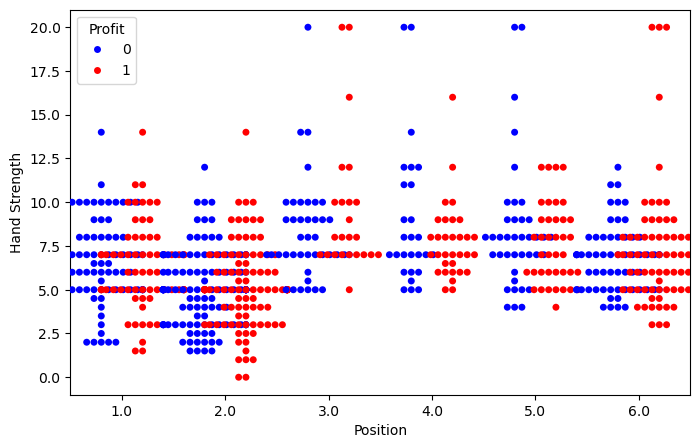

In [55]:
plt.figure(figsize=(8, 5))
sns.swarmplot(
    x=X_train[:, 2],  # Position (Categorical)
    y=X_train[:, 3],  # Hand Strength
    hue=y_train,      # Color by Profit (0 or 1)
    palette={0: "blue", 1: "red"}, 
    dodge=True
)
plt.xlabel("Position")
plt.ylabel("Hand Strength")
plt.legend(title="Profit")
plt.show()

In [75]:
model = KAN(width=[3,1,1], grid=3, k=3, device=device)  # Fixed grid parameter

def train_acc():
    preds = torch.round(model(dataset['train_input'])[:,0])
    labels = dataset['train_label'][:,0]  # Fixed slicing
    return torch.mean((preds == labels).float())  # Proper float conversion

def test_acc():
    preds = torch.round(model(dataset['test_input'])[:,0])
    labels = dataset['test_label'][:,0]  # Fixed slicing
    return torch.mean((preds == labels).float())  # Proper float conversion

results = model.fit(dataset, opt="LBFGS", steps=100, metrics=(train_acc, test_acc))

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 4.89e-01 | test_loss: 5.04e-01 | reg: 4.29e+00 | : 100%|█| 100/100 [00:17<00:00,  5.83

saving model version 0.1


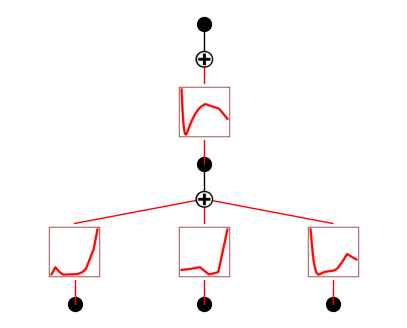

In [82]:
model.plot(beta=10)

In [77]:
model.suggest_symbolic(1,0,0,weight_simple=0.)

   function  fitting r2   r2 loss  complexity  complexity loss  total loss
0  gaussian    0.575011 -1.234468           3                3   -1.234468
1     1/x^5    0.502195 -1.006319           5                5   -1.006319
2     1/x^4    0.493888 -0.982442           4                4   -0.982442
3     1/x^3    0.480035 -0.943486           3                3   -0.943486
4     1/x^2    0.453214 -0.870926           2                2   -0.870926


('gaussian',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  3,
  <function kan.utils.<lambda>(x, y_th)>),
 0.5750109553337097,
 3)

In [78]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)

# model.fix_symbolic(0,0,0,'x^2')
# model.fix_symbolic(0,1,0,'sin')
# model.fix_symbolic(0,2,0,'cos')
# model.fix_symbolic(1,0,0,'sin')
# model.fix_symbolic(0,3,0,'x')

from kan.utils import ex_round
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.021518509835004807, c=1
fixing (0,1,0) with exp, r2=0.978762149810791, c=2
fixing (0,2,0) with x, r2=0.020470943301916122, c=1
fixing (1,0,0) with x, r2=0.01210497971624136, c=1
saving model version 0.2


0.0012*x_1 + 0.0004*x_3 + 0.4763

In [83]:
model.fix_symbolic(0,0,0,'sin')
model.fix_symbolic(0,1,0,'1/x^3')
model.fix_symbolic(0,2,0,'sin')
#model.fix_symbolic(0,3,0,'1/x^3')

r2 is 0.6840469837188721
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.9
r2 is 0.9829890131950378
saving model version 0.10
r2 is 0.504209041595459
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.11


-100000000.0

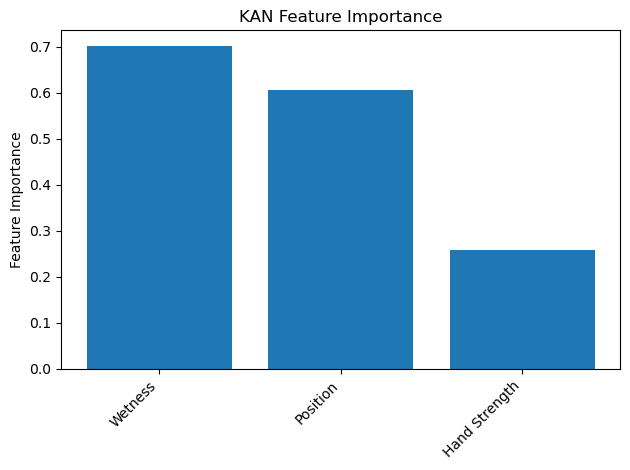

In [79]:
scores = model.feature_score  
scores_np = scores.detach().cpu().numpy()
feature_names = ['Wetness', 'Position', 'Hand Strength']

# Make sure the length matches
assert len(scores_np) == len(feature_names), (
    f"Expected {len(feature_names)} features, got {len(scores_np)} scores."
)

x_pos = np.arange(len(feature_names))
plt.bar(x_pos, scores_np, align='center')
plt.xticks(x_pos, feature_names, rotation=45, ha='right')
plt.ylabel('Feature Importance')
plt.title('KAN Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Suppose y_true and y_pred are your actual and predicted values:
plt.scatter(y_true_test, y_pred_test, alpha=0.7)
plt.plot([min(y_true_test), max(y_true_test)], [min(y_true_test), max(y_true_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual')
plt.show()

In [ ]:
def plot_spline_activations(model, feature_names, n_points=100):
    plt.figure(figsize=(12, 8))
    
    # Generate input range based on normalized data
    x_range = torch.linspace(-3, 3, n_points).to(device)
    
    for i, name in enumerate(feature_names):
        # Create dummy input with current feature variation
        dummy_input = torch.zeros(n_points, model.width[0]).to(device)
        dummy_input[:, i] = x_range  # Vary only current feature
        
        # Get spline outputs
        with torch.no_grad():
            activation = model.acts[0][i](dummy_input)  # First layer activations
            
        plt.subplot(2, 2, i+1)
        plt.plot(x_range.cpu(), activation.cpu()[:, i], lw=2)
        plt.title(f'{name} Spline Activation', fontsize=12)
        plt.xlabel('Normalized Input')
        plt.ylabel('Activation Output')
        plt.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()

# Usage
feature_names = ['Equity', 'Wetness', 'Position', 'Hand Strength']
plot_spline_activations(model, feature_names)